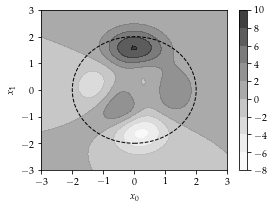

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, precision_score, recall_score

from oodx import DataBlock, GPR, GPC, NN, MPBlock, AdaptiveSampler
from utils import (
    BlackBox, plot_underlying, plot_samples, plot_gpr, plot_gpc, plot_gp_opt, plot_gp_adaptive_opt, plot_nnr,
    plot_nnc, plot_nn_opt, plot_nn_adaptive_opt, plot_bayesian_opt, plot_direct_search
)

plot_underlying()

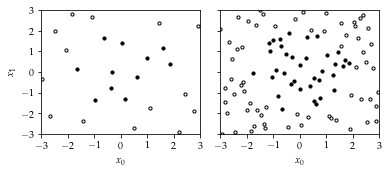

In [2]:
bb = BlackBox()
space = [[-3.0, 3.0], [-3.0, 3.0]]

db = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db.static_sample(25, space)
db.data.y = bb.sample_y(db.data[['x0', 'x1']].values)
db.data.t = bb.sample_t(db.data[['x0', 'x1']].values)

db2 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db2.static_sample(100, space)
db2.data.y = bb.sample_y(db2.data[['x0', 'x1']].values)
db2.data.t = bb.sample_t(db2.data[['x0', 'x1']].values)

db3 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db3.static_sample(500, space)
db3.data.y = bb.sample_y(db3.data[['x0', 'x1']].values)
db3.data.t = bb.sample_t(db3.data[['x0', 'x1']].values)

plot_samples(db, db2)
plt.savefig('../figures/samples.png', dpi=500)

0.9238003452832474
0.08881825632043405


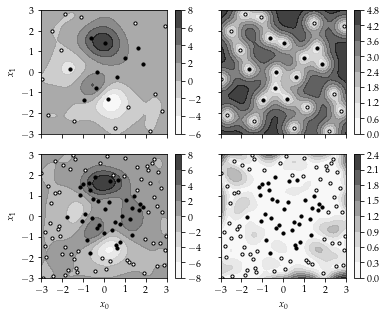

In [3]:
gpr = GPR()
gpr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = gpr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

gpr2 = GPR()
gpr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred2 = gpr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred2)[db3.data.t==1]))

plot_gpr(db, db2, gpr, gpr2)
plt.savefig('../figures/gpr.png', dpi=500)

0.7920792079207921 0.9467455621301775
0.9760479041916168 0.9644970414201184


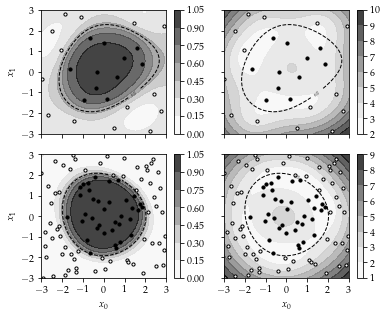

In [4]:
gpc = GPC()
gpc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

gpc2 = GPC()
gpc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_gpc(db, db2, gpc, gpc2)
plt.savefig('../figures/gpc.png', dpi=500)

In [5]:
def pyomo_problem(space, p):
    m = pyo.ConcreteModel()
    m.n_inputs = set(range(len(space)))
    m.inputs = pyo.Var(m.n_inputs, bounds=space)
    m.output = pyo.Var()
    m.prob = pyo.Var()
    m.feasibility_con = pyo.Constraint(expr= m.prob >= p)
    m.obj = pyo.Objective(expr=m.output, sense=pyo.maximize)
    return m

def gp_algorithm_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def gp_global_dfo(db, gpr, gpc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.5)

    gpr_block = MPBlock(gpr)
    gpc_block = MPBlock(gpc)
    omo.gpr = gpr_block.get_formulation()
    omo.gpc = gpc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.gpr.outputs[0])
    omo.connectors.add(omo.prob == omo.gpc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = gp_algorithm_results(omo, db, gpr, testing, times)
    
    return results

 BARON version 22.9.30. Built: OSX-64 Fri Sep 30 09:08:44 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1            14.37    -0.100000E+52      4.18343
*         2             2            14.45      1.80035          4.18343
*        

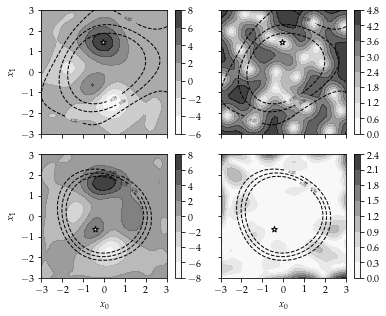

In [6]:
solver = pyo.SolverFactory('baron')
# solver.options['MaxTime'] = 120
results1 = gp_global_dfo(db, gpr, gpc, solver, db3)
results2 = gp_global_dfo(db2, gpr2, gpc2, solver, db3)

plot_gp_opt(db, db2, gpr, gpr2, gpc, gpc2, results1[['x0*', 'x1*']], results2[['x0*', 'x1*']])
plt.savefig('../figures/gpopt.png', dpi=500)

print(results1)
print(results2)

In [7]:
def dim_convergence_check(bounds, tol):
    if bounds[1] - bounds[0] <= tol:
        print('dimension converged')
        return 1
    else:
        return 0
    
def convergence_check(space, tol):
    checks = []
    for dim, bounds in enumerate(space):
        if dim_convergence_check(bounds, tol):
            checks.append(1)
    if len(checks) == len(space):
        print('converged')
        return 1
    else:
        return 0

def bt(space0, space, shrink, sol, tol, prox=0.001):
    for dim, (lb, ub) in enumerate(space):
        if dim_convergence_check(space[dim], tol) == 1:
            space[dim] = [sol[dim] - tol / 2, sol[dim] + tol / 2]
        elif sol[dim] <= lb + prox:
            print('lower bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        elif sol[dim] >= ub - prox:
            print('upper bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        else:
            print('shrinking dimension...')
            new_size = (ub - lb) * shrink
            space[dim] = [sol[dim] - new_size / 2, sol[dim] + new_size / 2]
    return space

def gp_adaptive_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def gp_adaptive_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_gp_std(gpr)
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        print(obj)
        plot_gp_adaptive_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), space)
        plt.savefig('../figures/gp_adaptive{}.png'.format(iteration), dpi=500)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = gp_adaptive_results(omo, d, gpr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, test_data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if convergence_check(space, 0.5) == 1:
            break
            
    return results.T

[7.55136632]
shrinking dimension...
shrinking dimension...
[7.5458366]
shrinking dimension...
shrinking dimension...
[7.55158851]
shrinking dimension...
shrinking dimension...
[7.54652702]
shrinking dimension...
shrinking dimension...
[7.58854263]
shrinking dimension...
shrinking dimension...
[7.56113234]
shrinking dimension...
shrinking dimension...
[7.57077893]
shrinking dimension...
shrinking dimension...
[7.87653229]
shrinking dimension...
shrinking dimension...
[7.86668439]
shrinking dimension...
shrinking dimension...
[7.88376321]
shrinking dimension...
shrinking dimension...
[7.89618315]
shrinking dimension...
shrinking dimension...
[8.00906766]
shrinking dimension...
shrinking dimension...
[8.01507165]
shrinking dimension...
shrinking dimension...
[8.05738031]
shrinking dimension...
shrinking dimension...
[8.05827783]
shrinking dimension...
shrinking dimension...
[8.08509623]
shrinking dimension...
shrinking dimension...
[8.18621417]
shrinking dimension...
shrinking dimension..

/Users/alexdurkin/phd/examples/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), sharex=True, sharey=True)


shrinking dimension...
shrinking dimension...
[8.11423461]
shrinking dimension...
shrinking dimension...
[8.11499401]
shrinking dimension...
shrinking dimension...
[8.10159139]
shrinking dimension...
shrinking dimension...
dimension converged
dimension converged
converged
         x0*       x1*       obj      prob       err       unc       tads  \
0  -0.051370  1.438286  7.551366  0.893530  0.918275  0.539532   0.854543   
1  -0.047501  1.438586  7.545837  0.891332  0.942675  0.492927   1.158894   
2  -0.050280  1.441013  7.551589  0.897388  0.938825  0.504919   0.976778   
3  -0.047917  1.439129  7.546527  0.902539  0.905846  0.480532   0.970792   
4  -0.040639  1.484140  7.588543  0.893260  0.635122  0.616197   1.049164   
5   0.005484  1.481883  7.561132  0.921698  0.600776  0.493971   1.069344   
6  -0.003969  1.487283  7.570779  0.890913  0.609908  0.483776   3.152204   
7  -0.014517  1.556571  7.876532  0.904897  0.251097  0.786540   2.063543   
8  -0.021863  1.549669  7.866684  

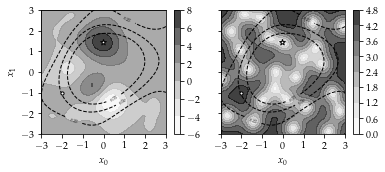

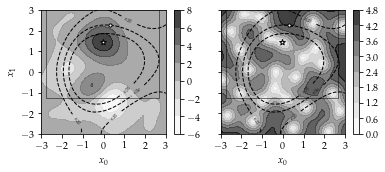

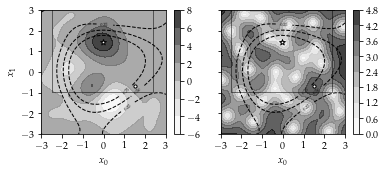

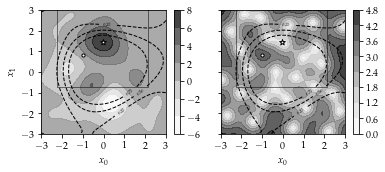

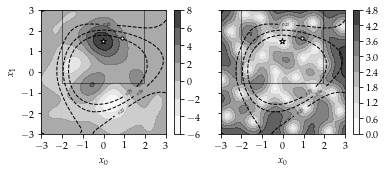

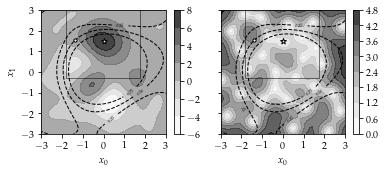

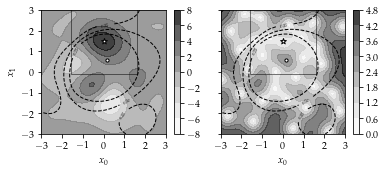

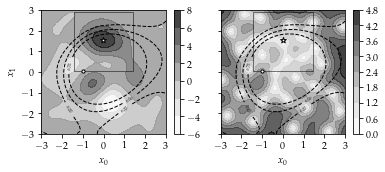

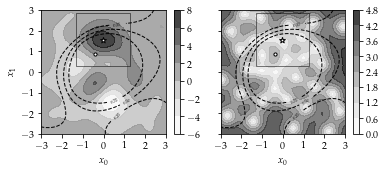

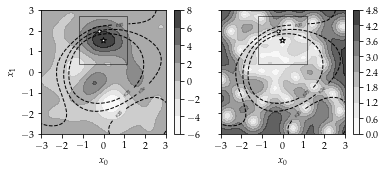

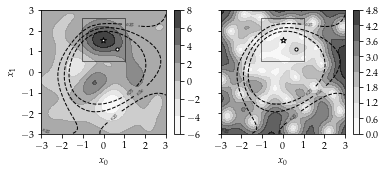

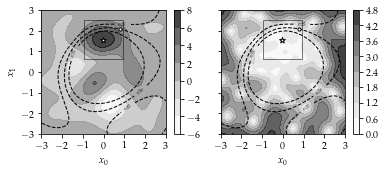

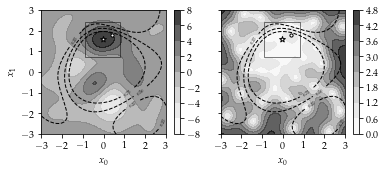

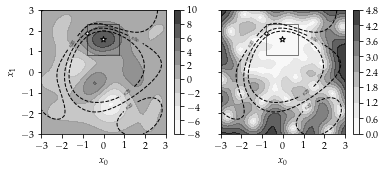

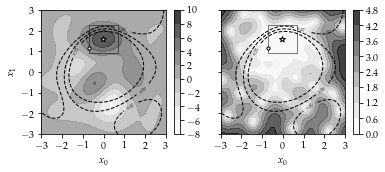

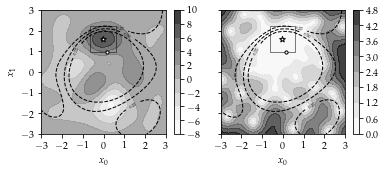

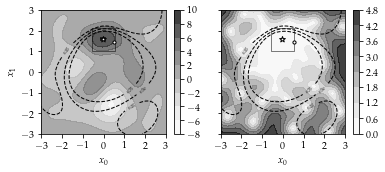

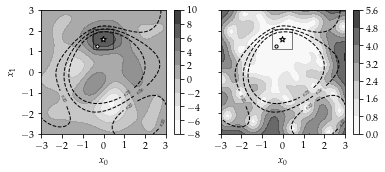

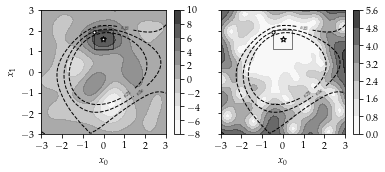

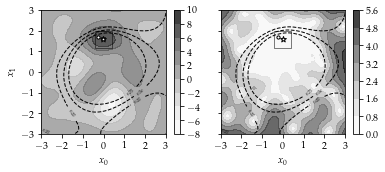

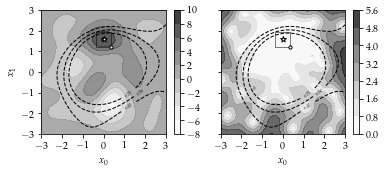

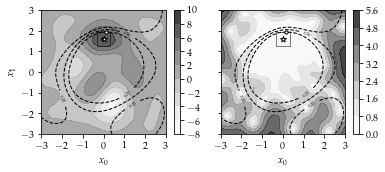

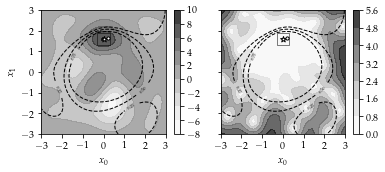

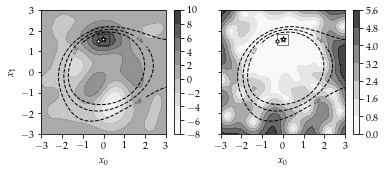

In [8]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results3 = gp_adaptive_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results3)

1.7523887982210165
0.9769572758168539


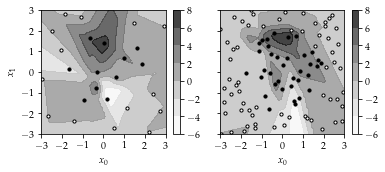

In [9]:
nnr = NN([2, 10, 10, 1], 'relu')
nnr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = nnr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

nnr2 = NN([2, 10, 10, 1], 'relu')
nnr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred = nnr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred)[db3.data.t==1]))

plot_nnr(db, db2, nnr, nnr2)
plt.savefig('../figures/nnr.png', dpi=500)

0.8134715025906736 0.9289940828402367
0.9875776397515528 0.9408284023668639


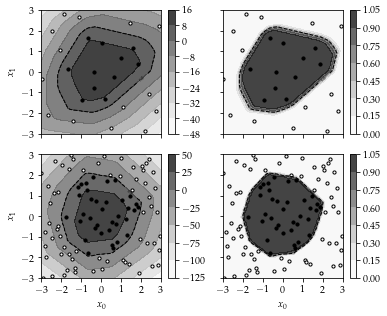

In [10]:
nnc = NN([2, 20, 1], 'relu', is_classifier=True)
nnc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

nnc2 = NN([2, 20, 1], 'relu', is_classifier=True)
nnc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_nnc(db, db2, nnc, nnc2)
plt.savefig('../figures/nnc.png', dpi=500)

In [11]:
def nn_algorithm_results(m, d, nn, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def nn_global_dfo(db, nnr, nnc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.0)

    nnr_block = MPBlock(nnr)
    nnc_block = MPBlock(nnc)
    omo.nnr = nnr_block.get_formulation()
    omo.nnc = nnc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.nnr.outputs[0])
    omo.connectors.add(omo.prob == omo.nnc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = nn_algorithm_results(omo, db, nnr, testing, times)
    
    return results

 BARON version 22.9.30. Built: OSX-64 Fri Sep 30 09:08:44 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             0.07      1.77833          5.40993
          1             0             0.07 

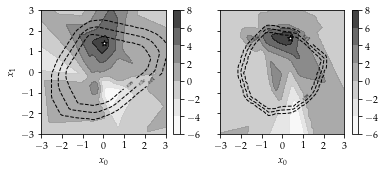

In [12]:
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30
results4 = nn_global_dfo(db, nnr, nnc, solver, db3)
results5 = nn_global_dfo(db2, nnr2, nnc2, solver, db3)

plot_nn_opt(db, db2, nnr, nnr2, nnc, nnc2, results4[['x0*', 'x1*']], results5[['x0*', 'x1*']])
plt.savefig('../figures/nnopt.png', dpi=500)
print(results4)
print(results5)

In [13]:
def nn_adaptive_results(m, d, nn, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value    
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results


def nn_adaptive_dfo(space, d, nnr, nnc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        nnr_block = MPBlock(nnr)
        nnc_block = MPBlock(nnc)
        
        omo = pyomo_problem(d.scale_space(space), 0.0)
        omo.nnr = nnr_block.get_formulation()
        omo.nnc = nnc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.nnr.outputs[0])
        omo.connectors.add(omo.prob == omo.nnc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=1)
        mod.nnc = nnc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.nnc.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.nnc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        plot_nn_adaptive_opt(d, nnr, nnc, x.ravel(), ads_x.ravel(), space, ads)
        plt.savefig('../figures/nn_adaptive{}.png'.format(iteration), dpi=500)
        
        nnr = NN([2, 10, 10, 1], 'relu')
        nnr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        nnc = NN([2, 20, 1], 'relu', is_classifier=True)
        nnc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = nn_adaptive_results(omo, d, nnr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, nn_adaptive_results(omo, d, nnr, test_data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
        if convergence_check(space, 0.5) == 1:
            break
            
    return results.T

shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...


/Users/alexdurkin/phd/examples/utils.py:367: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), sharex=True, sharey=True)


shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
shrinking dimension...
dimension converged
dimension converged
converged
         x0*       x1*        obj        lgt       err      tads      tomo  \
0   0.034009  1.387745   7.477644   8.509387  1.339185  0.049449  0.094633   
1  -0.016929  1.358507   8.064230   9.431302  1.967906  0.055825  0.103004   
2  -0.336060  1.412909   8.478174  10.899587  1.768767  0.058149  0.100880   
3   0.720981  1.027782   8.684883  14.151255  1.173586  0.075643  0.093710   
4   0.220330  0.993137   8.475626  18.311042  1.315573  0.048350  0.096080   
5  -0.249454  1.092687   7.161144  14.450087  1.166786  0.049378  0.093711   
6   0.081909  1.208348   7.483900  12.964384  1.887941  0.053038  0.094918   
7   0.078506  1.100289   8.208714  12.095601  0.718293  0.048437  0.092790   
8   0.062731  1.521588   8.397688   7.152313  0.697291  0.047645

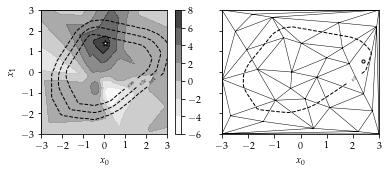

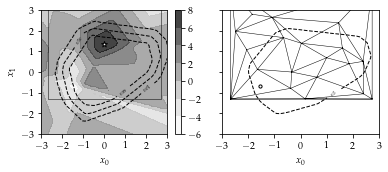

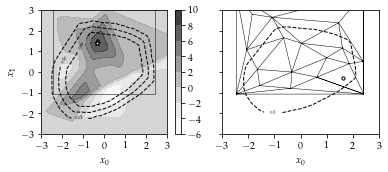

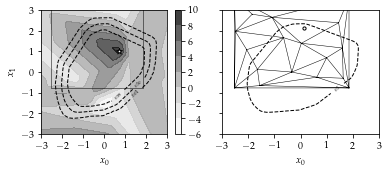

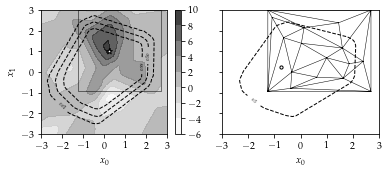

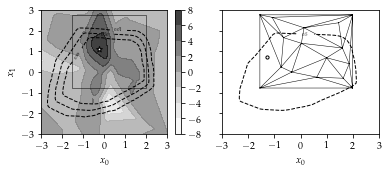

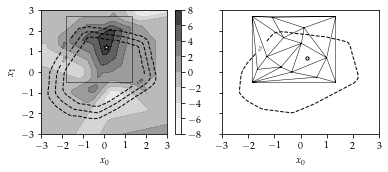

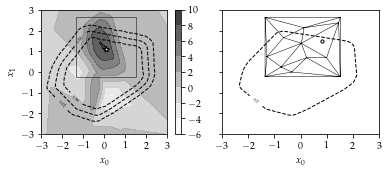

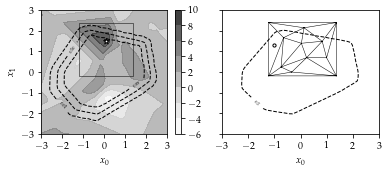

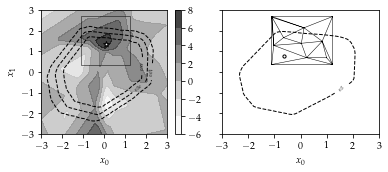

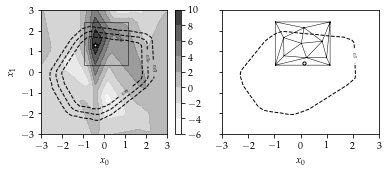

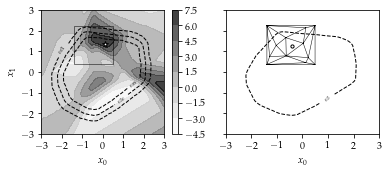

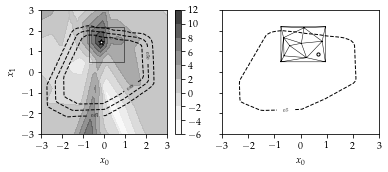

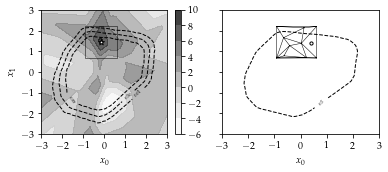

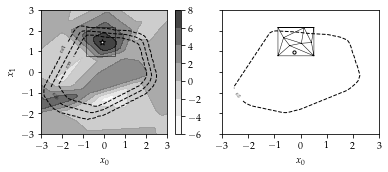

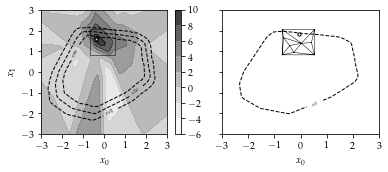

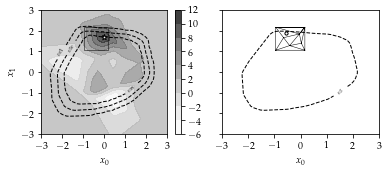

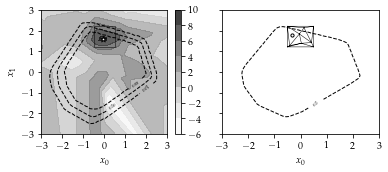

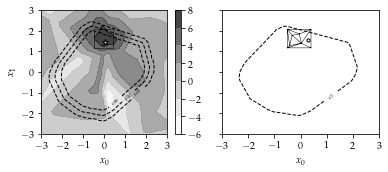

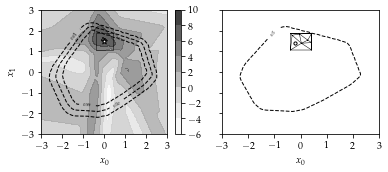

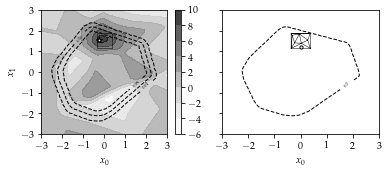

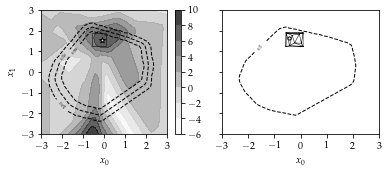

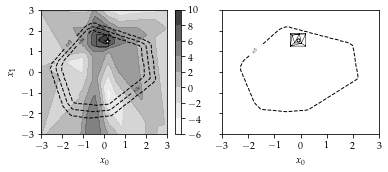

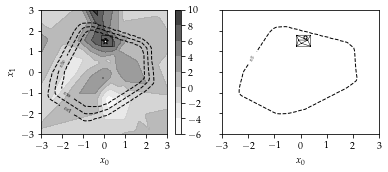

In [14]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annr = copy.deepcopy(nnr)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results6 = nn_adaptive_dfo(aspace, adb, annr, annc, 50, baron, db3)
print(results6)

In [15]:
def gp_bayesian_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.modified_expected_improvement(gpr, d.scaled_outputs.to_numpy(), 'max')
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        ystar = np.max(d.scaled_outputs.to_numpy())
        plot_bayesian_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), ystar)
        plt.savefig('../figures/gp_bayesian{}.png'.format(iteration), dpi=500)

        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
    
        times.append(time.time())
        
        if iteration == 0:
            results = gp_adaptive_results(omo, d, gpr, testing.data, times)
        else:
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, testing.data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
        if mod.mod_ei.value < 0.01:
            print('modified expected improvement converged')
            break
        
    return results.T

modified expected improvement converged
        x0*       x1*       obj      prob       err       unc      tads  \
0 -0.051370  1.438286  7.551366  0.893530  0.923800  0.539532  1.398397   
1 -0.049000  1.509996  8.475772  0.893530  0.806517  0.474741  1.442244   
2 -0.003613  1.640872  8.100886  0.897898  0.718518  0.197374  1.523531   
3 -0.011998  1.638515  8.388574  0.917226  0.659163  0.143960  1.499871   
4  0.006224  1.619498  8.411990  0.923153  0.613369  0.093592  1.393025   
5 -0.030768  1.615863  8.335140  0.922591  0.543861  0.087032  3.472590   
6 -0.036726  1.630487  8.218309  0.923124  0.532490  0.071177  3.819015   
7 -0.027120  1.625235  8.183884  0.931217  0.534029  0.062520  3.028862   
8  0.055126  1.572906  8.016252  0.941457  0.523397  0.070301  3.313071   
9  0.054478  1.571322  8.018960  0.935493  0.559194  0.072046  3.419356   

       tomo      ttot  
0  0.850803  3.064777  
1  0.906833  3.459081  
2  0.779061  3.094216  
3  0.815100  3.171597  
4  0.968275  3

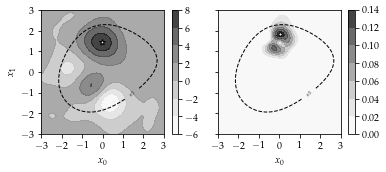

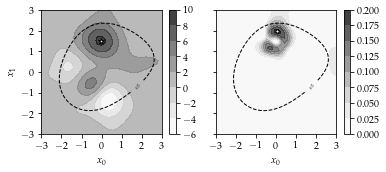

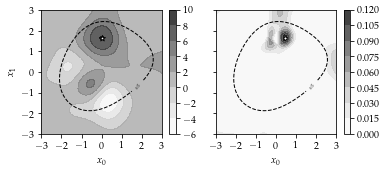

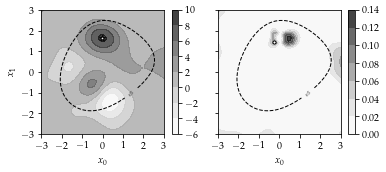

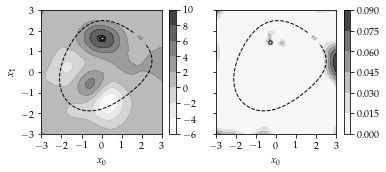

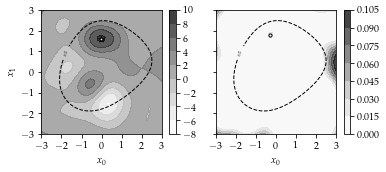

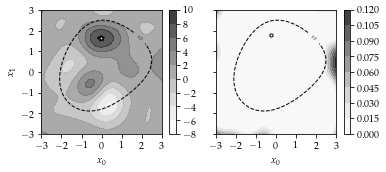

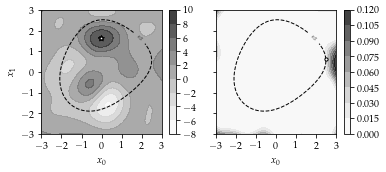

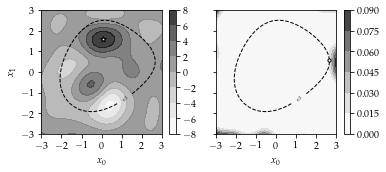

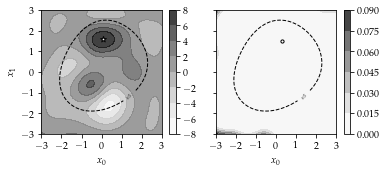

In [16]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results7 = gp_bayesian_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results7)

In [17]:
def direct_search_results(m, d, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = np.max(d.data.y.to_numpy())
    results['lgt'] = m.clf.outputs[0].value
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def direct_search_dfo(space, d, clf, max_iter, solver, testing):
    results = {}
    for iteration in range(max_iter):
        times = [time.time()]
        
        ads = AdaptiveSampler(d.scale_space(space))
        clf_block = MPBlock(clf)

        omo = ads.exploit_triangle(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), 'max', include_vertices=0)
        omo.clf = clf_block.get_formulation()
        omo.feas = pyo.Constraint(expr=omo.clf.outputs[0] >= 0.0)
        omo.connectors = pyo.ConstraintList()
        for i in omo.n_inputs:
            omo.connectors.add( omo.inputs[i] == omo.clf.inputs[i] )
            
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=0)
        mod.clf = clf_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.clf.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.clf.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        plot_direct_search(d, clf, x.ravel(), ads_x.ravel(), ads)
        plt.savefig('../figures/direct_search{}.png'.format(iteration), dpi=500)
        
        times.append(time.time())
        
        if iteration == 0:
            results = direct_search_results(omo, d, times)
        else:
            results = pd.concat([results, direct_search_results(omo, d, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        d.data.loc[len(d.data), :] = [*x[0], *bb.sample_y(x)[0], *bb.sample_t(x)[0]]
        clf = NN([2, 20, 1], 'relu', is_classifier=True)
        clf.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if iteration > 0:
            x_dist = np.sqrt(sum((results[iteration][i] - results[iteration - 1][i]) ** 2 for i in ['x0*', 'x1*']))
            if x_dist < 0.01:
                print('direct search converged')
                break
        
    return results.T

/Users/alexdurkin/phd/examples/utils.py:439: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(4, 3))


direct search converged
         x0*       x1*       obj        lgt      tads      tomo      ttot
0   1.028692  1.642144  7.479804   2.870299  0.047474  0.046531  0.382677
1   0.134172  2.137698  7.479804   2.441722  0.048595  0.048106  0.373631
2   0.231575  0.689736  7.479804  22.797404  0.089251  0.053227  0.450553
3   0.430848  1.240008  7.479804  13.166601  0.051212  0.049290  0.395373
4  -0.160212  1.728390  7.479804   3.961253  0.050735  0.051885  0.395065
5  -0.224375  1.841806  7.587903   2.424854  0.058308  0.057149  0.432387
6  -0.258340  1.591955  7.587903  11.492945  0.054191  0.056486  0.431108
7  -0.593631  1.281577  7.601922  14.560367  0.052346  0.052681  0.414066
8  -0.273232  1.420558  7.601922  14.833566  0.053484  0.053945  0.406284
9  -0.376600  1.697697  7.601922  10.014763  0.054857  0.061891  0.644320
10 -0.128759  1.569496  7.601922  11.353362  0.092141  0.058046  0.444954
11 -0.123238  1.459399  7.987789  16.716943  0.075168  0.081073  0.492621
12 -0.182437  

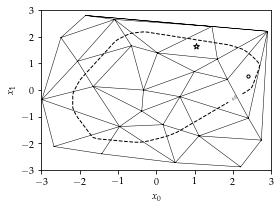

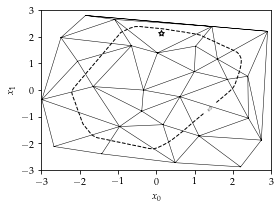

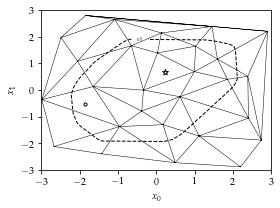

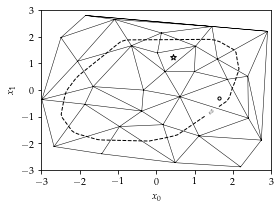

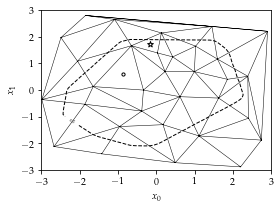

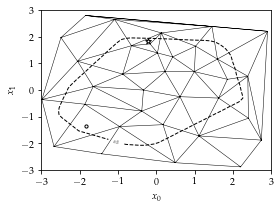

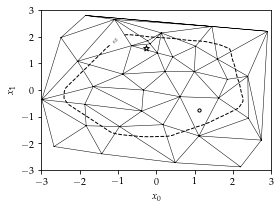

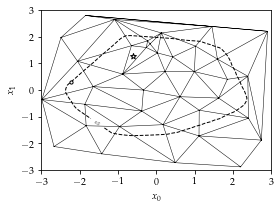

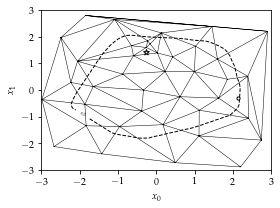

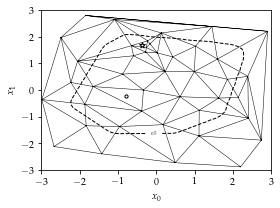

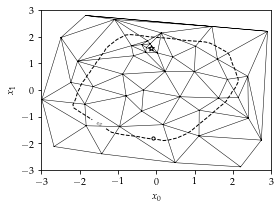

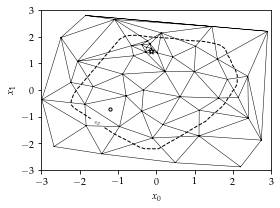

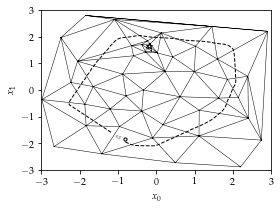

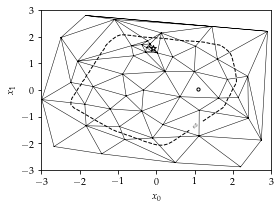

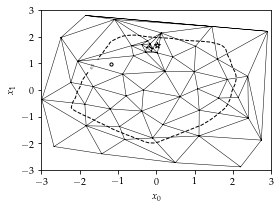

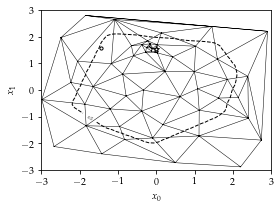

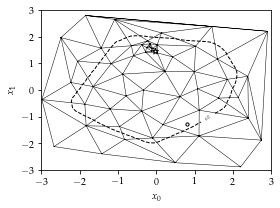

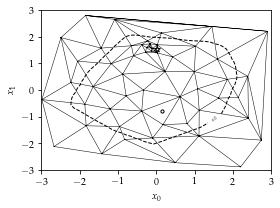

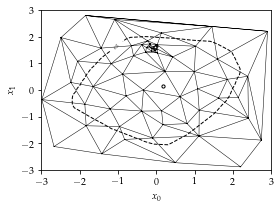

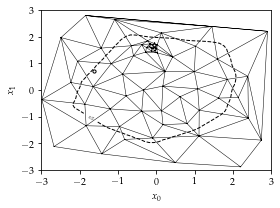

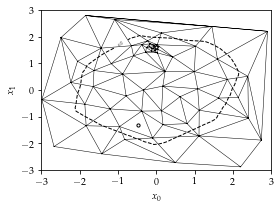

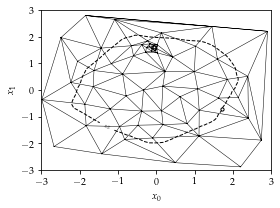

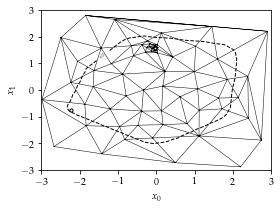

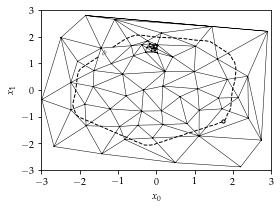

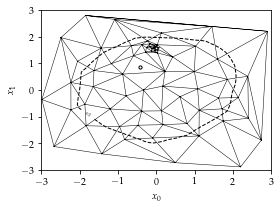

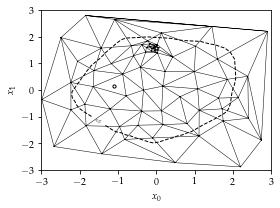

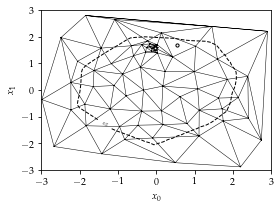

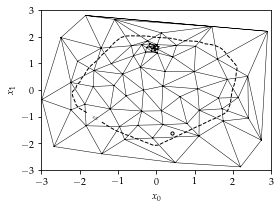

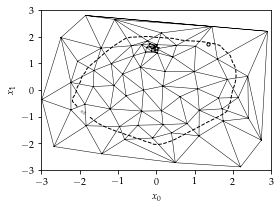

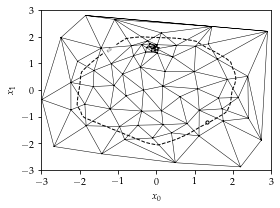

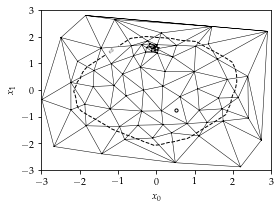

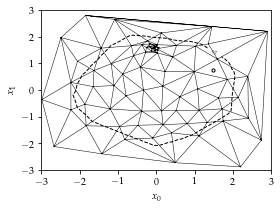

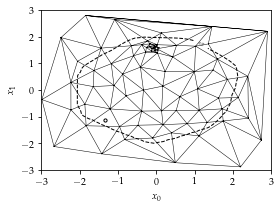

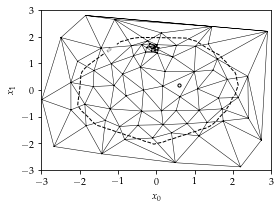

In [18]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results8 = direct_search_dfo(aspace, adb, annc, 50, baron, db3)
print(results8)

In [19]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

x0*     -0.051370
x1*      1.438286
obj      7.551366
prob     0.893530
err      0.923800
unc      0.539532
tsol    16.711579
ttot    16.765000
dtype: float64
x0*      -0.458578
x1*      -0.621890
obj       3.782395
prob      0.990873
err       0.088818
unc       0.038159
tsol    508.600114
ttot    509.329250
dtype: float64
         x0*       x1*       obj      prob       err       unc       tads  \
0  -0.051370  1.438286  7.551366  0.893530  0.918275  0.539532   0.854543   
1  -0.047501  1.438586  7.545837  0.891332  0.942675  0.492927   1.158894   
2  -0.050280  1.441013  7.551589  0.897388  0.938825  0.504919   0.976778   
3  -0.047917  1.439129  7.546527  0.902539  0.905846  0.480532   0.970792   
4  -0.040639  1.484140  7.588543  0.893260  0.635122  0.616197   1.049164   
5   0.005484  1.481883  7.561132  0.921698  0.600776  0.493971   1.069344   
6  -0.003969  1.487283  7.570779  0.890913  0.609908  0.483776   3.152204   
7  -0.014517  1.556571  7.876532  0.904897  0.251097  0.78

0.9238003452832474 16.764999866485596
0.08881825632043405 509.3292496204376
1.7523887982210165 0.18345403671264648
0.9769572758168539 0.12909412384033203
16.085224866867065


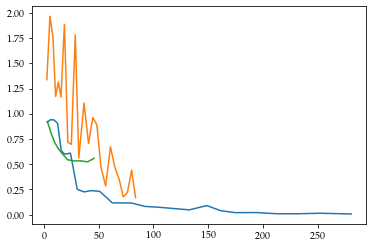

In [20]:
plt.plot(np.cumsum(results3.ttot), results3.err)
plt.plot(np.cumsum(results6.ttot), results6.err)
plt.plot(np.cumsum(results7.ttot), results7.err)

print(results1.err, results1.ttot)
print(results2.err, results2.ttot)

print(results4.err, results4.ttot)
print(results5.err, results5.ttot)

print(sum(results8.ttot))

7.551366308734329 16.764999866485596
3.7823945138264055 509.3292496204376
7.477643999187258 0.18345403671264648
6.841473800931292 0.12909412384033203


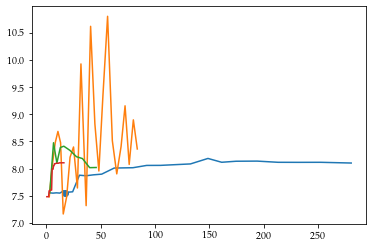

In [21]:
plt.plot(np.cumsum(results3.ttot), results3.obj)
plt.plot(np.cumsum(results6.ttot), results6.obj)
plt.plot(np.cumsum(results7.ttot), results7.obj)
plt.plot(np.cumsum(results8.ttot), results8.obj)
plt.scatter(results1.ttot, results1.obj)

print(results1.obj, results1.ttot)
print(results2.obj, results2.ttot)

print(results4.obj, results4.ttot)
print(results5.obj, results5.ttot)